In [1]:
from datasets import load_dataset
data = load_dataset('kde4', lang1='en', lang2='fr')
data

Found cached dataset kde4 (/home/przemek/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [2]:
small = data['train'].shuffle().select(range(1000))
split = small.train_test_split(seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [3]:
split['train'][0]

{'id': '150858',
 'translation': {'en': "Message Disposition Notification Policy MDNs are a generalization of what is commonly called read receipt. The message author requests a disposition notification to be sent and the receiver's mail program generates a reply from which the author can learn what happened to his message. Common disposition types include displayed (i. e. read), deleted and dispatched (e. g. forwarded). The following options are available to control KMail's sending of MDNs: Ignore: Ignores any request for disposition notifications. No MDN will ever be sent automatically (recommended). Ask: Answers requests only after asking the user for permission. This way, you can send MDNs for selected messages while denying or ignoring them for others. Deny: Always sends a denied notification. This is only slightly better than always sending MDNs. The author will still know that the messages has been acted upon, he just cannot tell whether it was deleted or read etc. Always send: 

In [4]:
from transformers import AutoTokenizer
checkpoint = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [5]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('FIBS is the First Internet Backgammon Server, a 24-hour international online community of backgammon players of all ages and experience from Beginner to Experts.',
 "L'abréviation FIBS désigne le First Internet Backgammon Server, une communauté de joueurs de backgammon de tous âges et de tous niveaux (du débutant à l'expert) en ligne 24 heures sur 24.")

In [6]:
inputs = tokenizer(en)
inputs

{'input_ids': [14970, 11435, 32, 4, 1492, 1159, 5658, 18114, 3974, 21490, 2, 15, 19670, 12518, 172, 1731, 809, 7, 717, 18114, 3974, 7321, 7, 98, 13521, 10, 1243, 64, 48685, 12, 8897, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
targets = tokenizer(text_target=fr)
targets

{'input_ids': [87, 6, 63, 18154, 2721, 446, 14970, 11435, 12236, 19, 1492, 1159, 5658, 18114, 3974, 21490, 2, 38, 1402, 5, 10822, 5, 717, 18114, 3974, 5, 182, 25052, 11, 5, 182, 1741, 24, 2073, 34222, 17, 14, 6, 16993, 28, 23, 863, 564, 972, 36, 8456, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁L',
 "'",
 'a',
 'bré',
 'vi',
 'ation',
 '▁FI',
 'BS',
 '▁désigne',
 '▁le',
 '▁First',
 '▁Internet',
 '▁Back',
 'gam',
 'mon',
 '▁Server',
 ',',
 '▁une',
 '▁communauté',
 '▁de',
 '▁joueurs',
 '▁de',
 '▁back',
 'gam',
 'mon',
 '▁de',
 '▁tous',
 '▁âges',
 '▁et',
 '▁de',
 '▁tous',
 '▁niveaux',
 '▁(',
 'du',
 '▁débutant',
 '▁à',
 '▁l',
 "'",
 'expert',
 ')',
 '▁en',
 '▁ligne',
 '▁24',
 '▁heures',
 '▁sur',
 '▁24.',
 '</s>']

In [9]:
#bad_targets = tokenizer(fr)
#tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

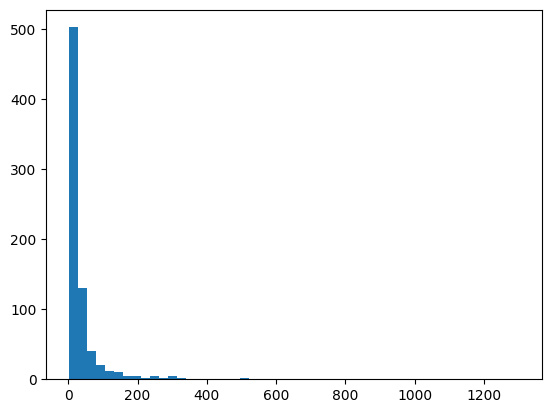

In [10]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

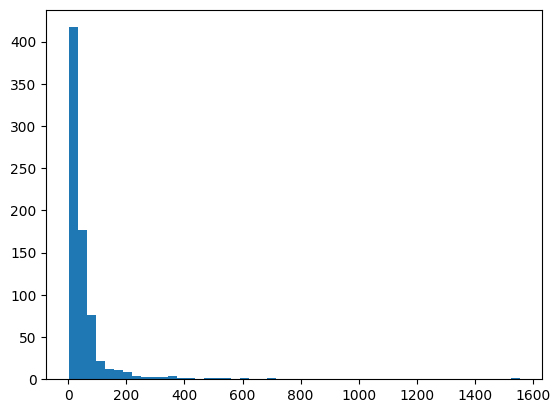

In [11]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [12]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
    inputs = [x['en'] for x in batch['translation']]
    outputs = [x['fr'] for x in batch['translation']]
    
    tokenized_inputs = tokenizer(inputs, max_length=max_input_len, truncation=True)    
    tokenized_targets = tokenizer(text_target=outputs, max_length=max_target_len, truncation=True)
    
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    
    return tokenized_inputs

In [13]:
tokenized_datasets = split.map(
    tokenizer_fn, 
    batched=True,
    remove_columns=split['train'].column_names,
    )

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [14]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [15]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
[tokenized_datasets["train"][i] for i in range(3, 5)]

[{'input_ids': [13640, 3582, 5990, 0],
  'attention_mask': [1, 1, 1, 1],
  'labels': [12287, 24393, 0]},
 {'input_ids': [28944, 0], 'attention_mask': [1, 1], 'labels': [24251, 0]}]

In [17]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(3, 5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [18]:
batch["labels"]

tensor([[12287, 24393,     0],
        [24251,     0,  -100]])

In [19]:
batch["decoder_input_ids"]

tensor([[59513, 12287, 24393],
        [59513, 24251,     0]])

In [20]:
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>', '▁Couleur', '▁ambiante']

In [21]:
split['train'][3]

{'id': '59667',
 'translation': {'en': 'Ambient color', 'fr': 'Couleur ambiante'}}

In [22]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

/tmp/ipykernel_27791/3816762898.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [23]:
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])
#bleu_metric.compute(predictions=["I love all cats"], references=[["I love all cats"]])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [24]:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [25]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803368449211121],
 'recall': [0.9803368449211121],
 'f1': [0.9803368449211121],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.30.2)'}

In [26]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [27]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [28]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [29]:
trainer.evaluate(max_length=max_target_len)

/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.5923453569412231,
 'eval_bleu': 40.43204438975351,
 'eval_bert_score': 0.8752822265625,
 'eval_runtime': 12.4458,
 'eval_samples_per_second': 20.087,
 'eval_steps_per_second': 0.161}

In [30]:
trainer.train()

/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=36, training_loss=1.657247437371148, metrics={'train_runtime': 17.7674, 'train_samples_per_second': 126.636, 'train_steps_per_second': 2.026, 'total_flos': 52985263030272.0, 'train_loss': 1.657247437371148, 'epoch': 3.0})

In [31]:
trainer.evaluate(max_length=max_target_len)

/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.4312129020690918,
 'eval_bleu': 42.82991687615935,
 'eval_bert_score': 0.8852023456096649,
 'eval_runtime': 10.1087,
 'eval_samples_per_second': 24.731,
 'eval_steps_per_second': 0.198,
 'epoch': 3.0}

In [32]:
trainer.save_model("my_saved_model")

In [33]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [34]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]